In [1]:
# --- 0. INSTALL & IMPORTS ---

!pip -q install tensorflow opencv-python-headless numpy pandas scikit-learn matplotlib pillow kaggle

import os, stat, json, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# --- 0.1 REPRODUCIBILITY ---

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
# --- 1. MOUNT DRIVE (OPTIONAL, if you want to save models to Drive) ---

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- 1.1 KAGGLE SETUP ---

from google.colab import files

uploaded = files.upload()
if 'kaggle.json' not in uploaded:
    raise SystemExit("Please upload kaggle.json (Kaggle -> Account -> Create API Token)")

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])
os.chmod('/root/.kaggle/kaggle.json', stat.S_IRUSR | stat.S_IWUSR)

print("kaggle.json installed")


Saving kaggle.json to kaggle.json
kaggle.json installed


In [5]:
# --- 1.2 DOWNLOAD DATASET ---

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri -p /content --unzip

!ls -la /content | sed -n '1,120p'


Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.77GB/s]
total 32
drwxr-xr-x 1 root root 4096 Nov 23 00:25 .
drwxr-xr-x 1 root root 4096 Nov 23 00:11 ..
drwxr-xr-x 4 root root 4096 Nov 20 14:30 .config
drwx------ 5 root root 4096 Nov 23 00:24 drive
-rw-r--r-- 1 root root   65 Nov 23 00:25 kaggle.json
drwxr-xr-x 1 root root 4096 Nov 20 14:30 sample_data
drwxr-xr-x 6 root root 4096 Nov 23 00:25 Testing
drwxr-xr-x 6 root root 4096 Nov 23 00:25 Training


In [16]:
# --- 1.3 PROJECT DIRECTORIES ---

PROJECT_DIR = '/content/brain-tumor-capstone'
MODEL_DIR   = os.path.join(PROJECT_DIR, 'models')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

TRAIN_DIR = '/content/Training'
TEST_DIR  = '/content/Testing'

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train classes: ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']
Test classes: ['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']


In [7]:
# --- 2. DATA GENERATORS ---

IMG_SIZE   = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    validation_split=0.15,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.03,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Test generator: no augmentation
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes   = train_generator.num_classes
class_indices = train_generator.class_indices
idx_to_label  = {v: k for k, v in class_indices.items()}

print("Class indices:", class_indices)


Found 2441 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [8]:
# --- 2.1 CLASS WEIGHTS ---

y_train = train_generator.classes
cw = compute_class_weight(class_weight='balanced',
                          classes=np.unique(y_train),
                          y=y_train)
class_weights = {i: float(w) for i, w in enumerate(cw)}
print("Class weights:", class_weights)


Class weights: {0: 0.8680654338549075, 1: 0.873032904148784, 2: 1.8162202380952381, 3: 0.8680654338549075}


In [9]:
# --- 3.1 CUSTOM CNN BASELINE ---

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="custom_cnn")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
# --- 3.2 TRANSFER LEARNING MODEL: EfficientNetB0 WITH GRAD-CAM SUPPORT ---
def build_efficientnet_b0_with_gradcam(input_shape=(224,224,3), num_classes=4):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base.trainable = False  # for warm-up

    inputs = layers.Input(shape=input_shape, name="input_image")
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    conv_outputs = base(x, training=False)   # <-- feature maps for Grad-CAM

    x = layers.GlobalAveragePooling2D(name="gap")(conv_outputs)
    x = layers.Dropout(0.4, name="dropout_1")(x)
    x = layers.Dense(256, activation='relu', name="dense_1")(x)
    x = layers.Dropout(0.3, name="dropout_2")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

    # Main classifier
    model = models.Model(inputs=inputs, outputs=outputs, name="efficientnet_b0")

    # Grad-CAM model: SAME input, but outputs (conv feature maps, predictions)
    grad_model = models.Model(
        inputs=inputs,
        outputs=[conv_outputs, outputs],
        name="efficientnet_b0_gradcam"
    )

    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, grad_model, base

In [11]:
# --- 4. TRAINING & EVALUATION HELPERS ---

def get_callbacks(model_name):
    ckpt_path = os.path.join(MODEL_DIR, f"{model_name}_best.keras")
    checkpoint = ModelCheckpoint(
        ckpt_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    es = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    rlr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    return [checkpoint, es, rlr]


def train_model(model, train_gen, val_gen, class_weights=None, epochs_warm=3, epochs_fine=12, base=None):
    history_all = {}

    # WARM-UP (for transfer models) or just training (for custom CNN)
    callbacks = get_callbacks(model.name)
    history = model.fit(
        train_gen,
        epochs=epochs_warm,
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks
    )
    for k, v in history.history.items():
        history_all.setdefault(k, []).extend(v)

    # FINE-TUNING (only if base is provided AND epochs_fine > 0)
    if base is not None and epochs_fine > 0:
        for layer in base.layers:
            layer.trainable = True
        model.compile(
            optimizer=optimizers.Adam(1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        callbacks = get_callbacks(model.name)
        history2 = model.fit(
            train_gen,
            epochs=epochs_fine,
            validation_data=val_gen,
            class_weight=class_weights,
            callbacks=callbacks
        )
        for k, v in history2.history.items():
            history_all.setdefault(k, []).extend(v)

    return history_all


def evaluate_model(model, generator, split_name="Test"):
    y_true = generator.classes
    y_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = (y_true == y_pred).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\n=== {split_name} Evaluation ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Macro F1: {macro_f1:.4f}\n")

    print(classification_report(
        y_true, y_pred,
        target_names=[idx_to_label[i] for i in range(num_classes)],
        digits=4
    ))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    return acc, macro_f1, cm

In [26]:
# --- 5.1 TRAIN CUSTOM CNN (BASELINE) ---

custom_cnn = build_custom_cnn(input_shape=(224,224,3), num_classes=num_classes)
custom_history = train_model(
    custom_cnn,
    train_generator,
    val_generator,
    class_weights=class_weights,
    epochs_warm=15,   # no fine-tune phase for custom CNN
    epochs_fine=0,
    base=None
)

print("Custom CNN - Validation:")
evaluate_model(custom_cnn, val_generator, "Validation")
print("Custom CNN - Test:")
evaluate_model(custom_cnn, test_generator, "Test")


Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5108 - loss: 1.2294
Epoch 1: val_accuracy improved from -inf to 0.28438, saving model to /content/brain-tumor-capstone/models/custom_cnn_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.5111 - loss: 1.2285 - val_accuracy: 0.2844 - val_loss: 1.5985 - learning_rate: 0.0010
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6300 - loss: 0.8944
Epoch 2: val_accuracy improved from 0.28438 to 0.37063, saving model to /content/brain-tumor-capstone/models/custom_cnn_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.6300 - loss: 0.8943 - val_accuracy: 0.3706 - val_loss: 2.6065 - learning_rate: 0.0010
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6659 - loss: 0.8058
Epoch 3: val_accuracy improved from 0.37063 to 0.57343, saving model to /content/brain-tumor-capstone/models/custom_cnn_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.

(np.float64(0.3883248730964467),
 0.3318603405321896,
 array([[ 3, 27, 55, 15],
        [ 0, 28, 71, 16],
        [ 0,  7, 86, 12],
        [ 0,  7, 31, 36]]))

In [27]:
# --- 5.2 TRAIN EFFICIENTNETB0 ---

eff_model, eff_grad_model, eff_base = build_efficientnet_b0_with_gradcam(
    input_shape=(224,224,3),
    num_classes=num_classes
)

eff_history = train_model(
    eff_model,
    train_generator,
    val_generator,
    class_weights=class_weights,
    epochs_warm=5,   # 5 epochs total for quick testing
    epochs_fine=10,   # no fine-tuning phase for now
    base=eff_base
)

print("EfficientNetB0 - Validation:")
evaluate_model(eff_model, val_generator, "Validation")
print("EfficientNetB0 - Test:")
evaluate_model(eff_model, test_generator, "Test")


Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4067 - loss: 1.3212
Epoch 1: val_accuracy improved from -inf to 0.59207, saving model to /content/brain-tumor-capstone/models/efficientnet_b0_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - accuracy: 0.4073 - loss: 1.3201 - val_accuracy: 0.5921 - val_loss: 0.9328 - learning_rate: 1.0000e-04
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6644 - loss: 0.8583
Epoch 2: val_accuracy improved from 0.59207 to 0.66667, saving model to /content/brain-tumor-capstone/models/efficientnet_b0_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 34s 224ms/step - accuracy: 0.6645 - loss: 0.8580 - val_accuracy: 0.6667 - val_loss: 0.7289 - learning_rate: 1.0000e-04
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7124 - loss: 0.7239
Epoch 3: val_accuracy improved from 0.66667 to 0.71562, saving model to /content/brain-tumor-capstone/models/efficientnet_b0_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms

(np.float64(0.6065989847715736),
 0.5749485223607472,
 array([[ 26,  32,  37,   5],
        [  0,  77,  35,   3],
        [  0,   2, 103,   0],
        [  0,  13,  28,  33]]))

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def _pick_key(keys, candidates):
    for c in candidates:
        if c in keys:
            return c
    # fallback: try fuzzy contains
    for k in keys:
        if any(c in k for c in candidates):
            return k
    return None

def plot_history(history, title="Training history"):
    """
    history: Keras History object OR dict with lists
    """
    h = history.history if hasattr(history, "history") else history
    keys = set(h.keys())

    acc_key     = _pick_key(keys, ["accuracy", "acc", "categorical_accuracy"])
    val_acc_key = _pick_key(keys, ["val_accuracy", "val_acc", "val_categorical_accuracy"])
    loss_key    = _pick_key(keys, ["loss"])
    val_loss_key= _pick_key(keys, ["val_loss"])

    if acc_key is None or val_acc_key is None or loss_key is None or val_loss_key is None:
        print("Could not find expected keys in history. Found keys:", sorted(keys))
        raise KeyError("Missing accuracy/loss keys in history.")

    epochs_acc  = np.arange(1, len(h[acc_key]) + 1)
    epochs_loss = np.arange(1, len(h[loss_key]) + 1)

    # Accuracy
    plt.figure(figsize=(7,4))
    plt.plot(epochs_acc, h[acc_key], label="Train Acc")
    plt.plot(epochs_acc, h[val_acc_key], label="Val Acc")
    plt.title(f"{title} – Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(epochs_loss, h[loss_key], label="Train Loss")
    plt.plot(epochs_loss, h[val_loss_key], label="Val Loss")
    plt.title(f"{title} – Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

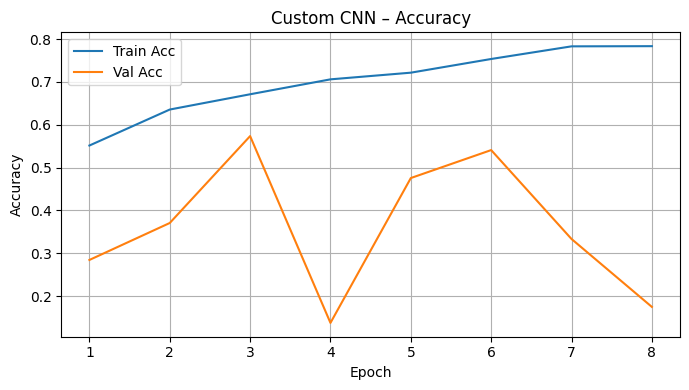

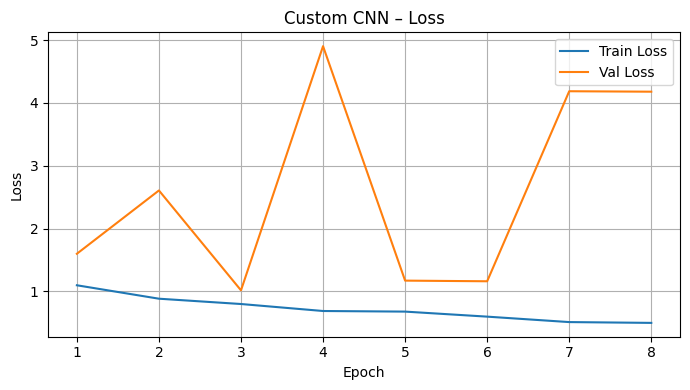

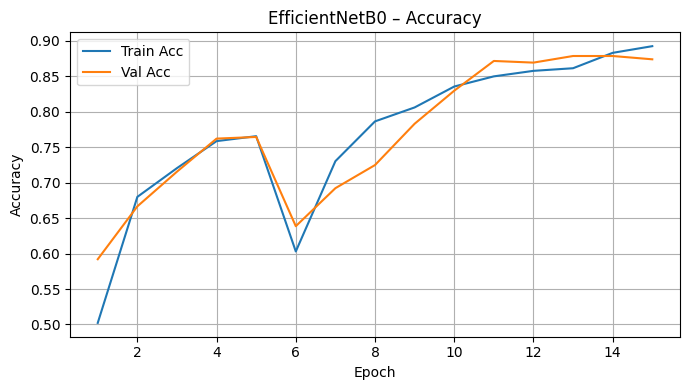

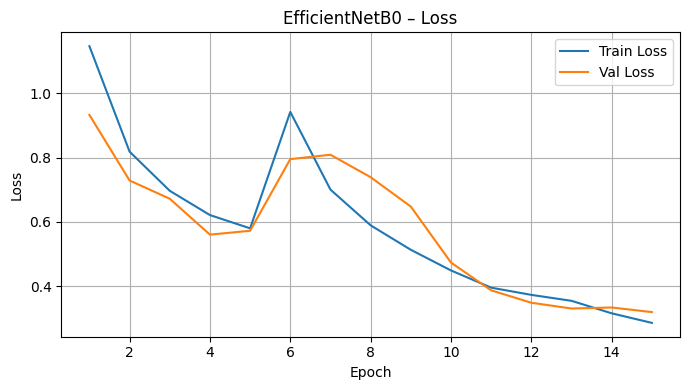

In [29]:
# If you trained with your helper (returns dict)
plot_history(custom_history, title="Custom CNN")
plot_history(eff_history, title="EfficientNetB0")

# If you ever have a raw Keras History object:
# hist = model.fit(...)
# plot_history(hist, title="Some Model")


In [30]:
 # --- 6. GRAD-CAM FOR EFFICIENTNETB0 (USING eff_grad_model) ---

import cv2
from tensorflow.keras.preprocessing import image

# You can keep this ON or OFF; it's not mandatory now
# tf.config.run_functions_eagerly(True)

def load_raw_image(img_path, size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    arr = image.img_to_array(img).astype("float32")  # (H,W,3)
    arr = np.expand_dims(arr, axis=0)                # (1,H,W,3)
    return arr, np.array(img)                        # original RGB image as numpy


def make_gradcam_heatmap_with_grad_model(grad_model, img_array):
    """
    grad_model: eff_grad_model (outputs conv feature maps + predictions)
    img_array:  (1,224,224,3) raw image (0-255)
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)      # (1,Hc,Wc,C)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))      # (C,)

    conv_outputs = conv_outputs[0]                          # (Hc,Wc,C)

    # Weighted sum of feature maps
    heatmap = tf.tensordot(conv_outputs, pooled_grads, axes=(2,0))  # (Hc,Wc)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy(), int(pred_index.numpy())


def overlay_heatmap_on_image(orig_img, heatmap, alpha=0.4):
    """
    orig_img: (H,W,3) RGB uint8 image
    heatmap: 2D array (Hc,Wc) with values in [0,1]
    """
    h, w, _ = orig_img.shape
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(heatmap_color, alpha, orig_img, 1 - alpha, 0)
    return overlay

Sample image path: /content/Testing/glioma_tumor/image(63).jpg


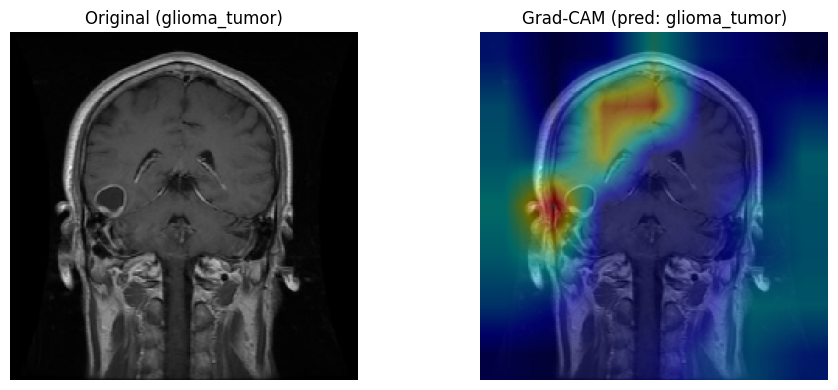

In [31]:
# --- 6.1 EXAMPLE GRAD-CAM VISUALIZATION ---

# Choose a sample from the test set
sample_class = sorted(os.listdir(TEST_DIR))[0]
sample_path = os.path.join(
    TEST_DIR,
    sample_class,
    os.listdir(os.path.join(TEST_DIR, sample_class))[0]
)

print("Sample image path:", sample_path)

img_array, orig_img = load_raw_image(sample_path, size=IMG_SIZE)

# IMPORTANT: use eff_grad_model here, NOT eff_model
heatmap, pred_idx = make_gradcam_heatmap_with_grad_model(eff_grad_model, img_array)
pred_class = idx_to_label[pred_idx]

overlay = overlay_heatmap_on_image(orig_img.astype("uint8"), heatmap, alpha=0.4)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(f"Original ({sample_class})")
plt.imshow(orig_img.astype("uint8"))
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"Grad-CAM (pred: {pred_class})")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

Total test images found: 394

[1/10] Image path: /content/Testing/meningioma_tumor/image(90).jpg
  Ground truth label: meningioma_tumor
  Predicted label   : meningioma_tumor


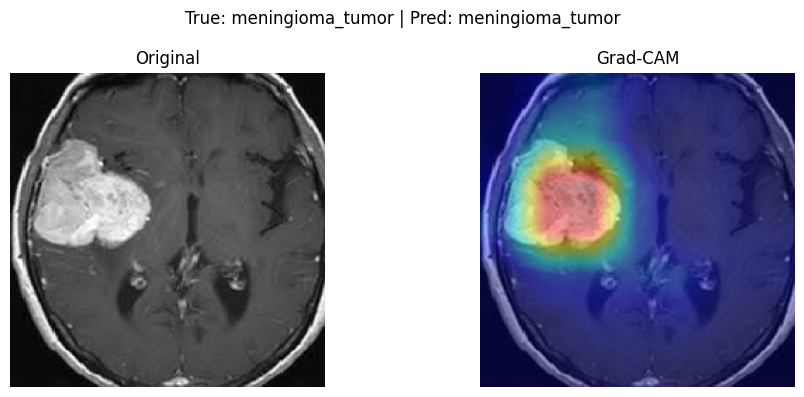


[2/10] Image path: /content/Testing/glioma_tumor/image(2).jpg
  Ground truth label: glioma_tumor
  Predicted label   : no_tumor


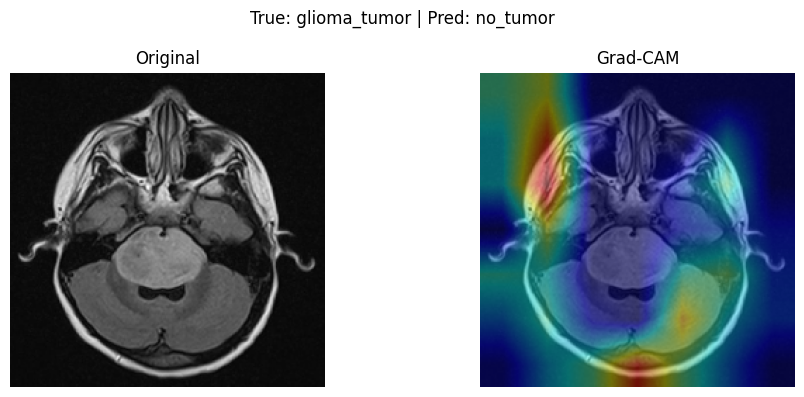


[3/10] Image path: /content/Testing/meningioma_tumor/image(72).jpg
  Ground truth label: meningioma_tumor
  Predicted label   : meningioma_tumor


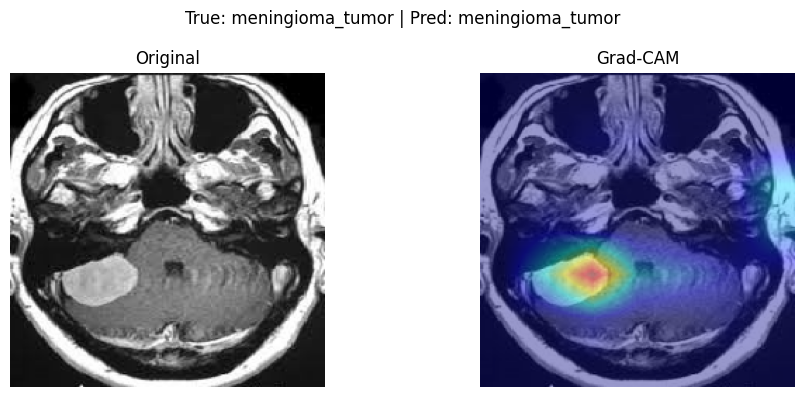


[4/10] Image path: /content/Testing/pituitary_tumor/image.jpg
  Ground truth label: pituitary_tumor
  Predicted label   : pituitary_tumor


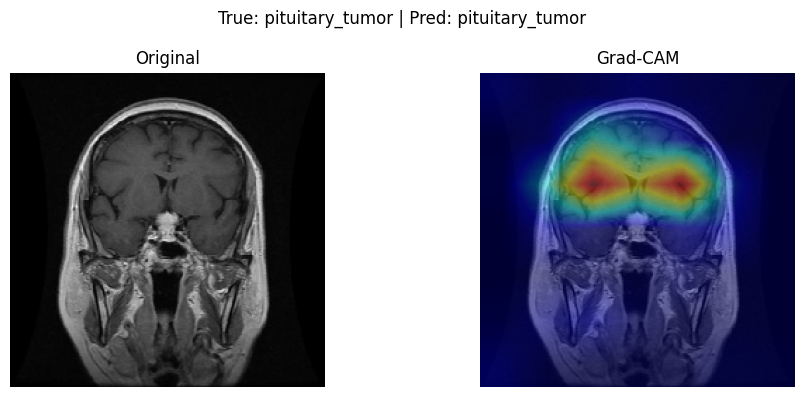


[5/10] Image path: /content/Testing/no_tumor/image(11).jpg
  Ground truth label: no_tumor
  Predicted label   : no_tumor


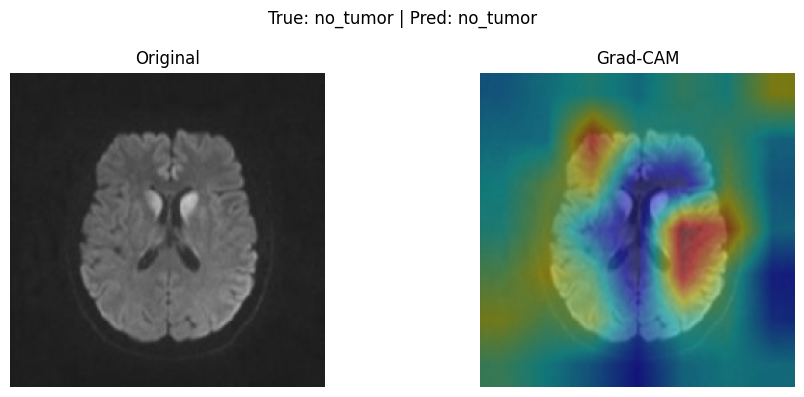


[6/10] Image path: /content/Testing/no_tumor/image(77).jpg
  Ground truth label: no_tumor
  Predicted label   : no_tumor


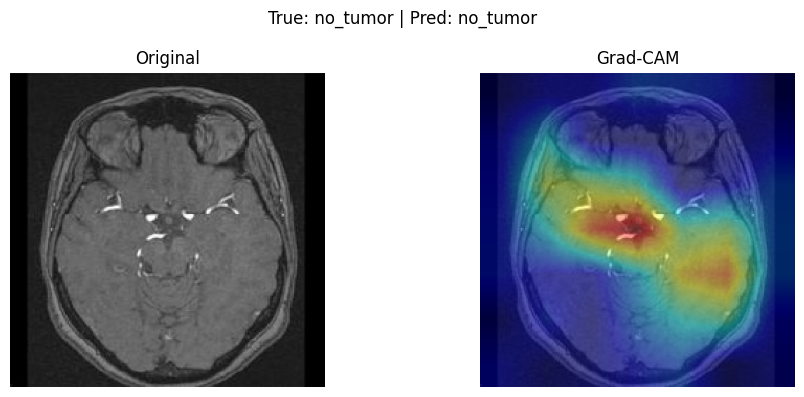


[7/10] Image path: /content/Testing/meningioma_tumor/image(16).jpg
  Ground truth label: meningioma_tumor
  Predicted label   : meningioma_tumor


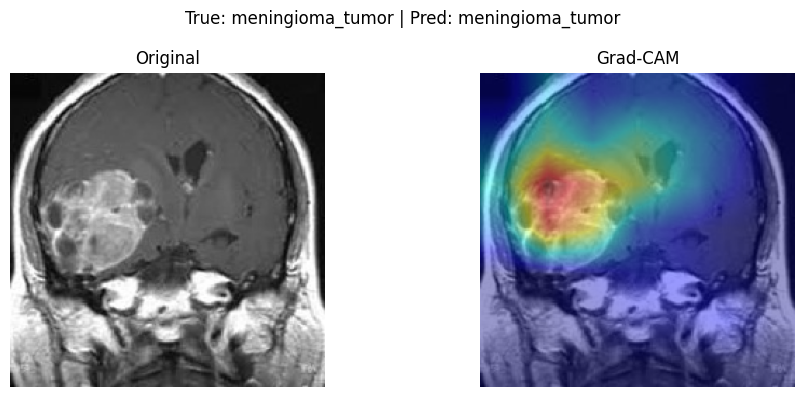


[8/10] Image path: /content/Testing/meningioma_tumor/image(34).jpg
  Ground truth label: meningioma_tumor
  Predicted label   : meningioma_tumor


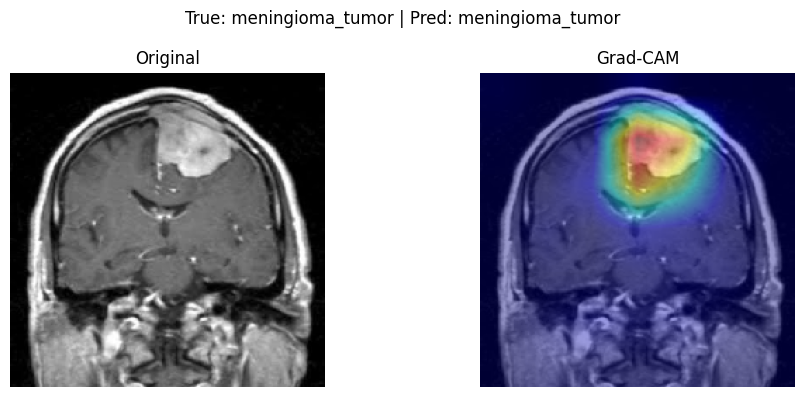


[9/10] Image path: /content/Testing/glioma_tumor/image(35).jpg
  Ground truth label: glioma_tumor
  Predicted label   : meningioma_tumor


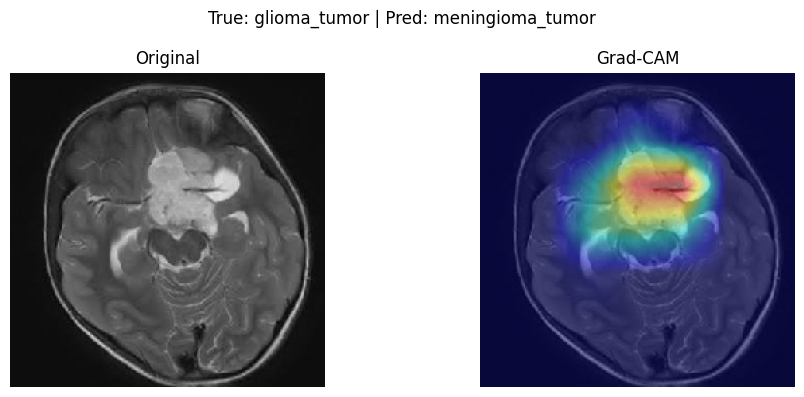


[10/10] Image path: /content/Testing/pituitary_tumor/image(7).jpg
  Ground truth label: pituitary_tumor
  Predicted label   : pituitary_tumor


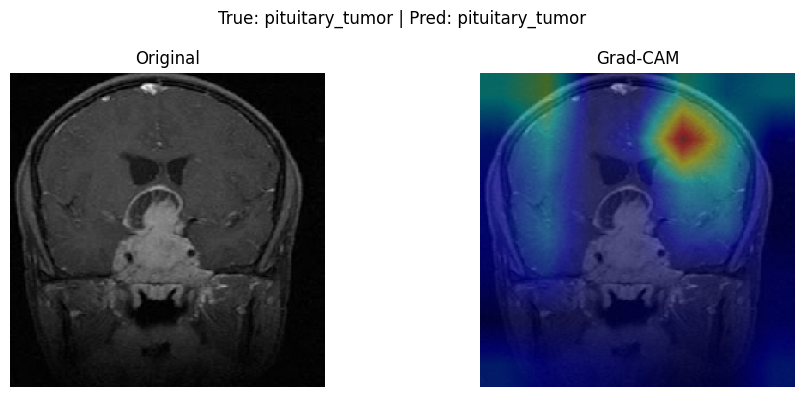

In [32]:
import random

# --- RANDOM 10 GRAD-CAM VISUALIZATIONS FROM TEST SET ---

# 1. Collect all test image paths with their true labels
all_test_images = []
for cls in sorted(os.listdir(TEST_DIR)):
    cls_dir = os.path.join(TEST_DIR, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            all_test_images.append((cls, os.path.join(cls_dir, fname)))

print(f"Total test images found: {len(all_test_images)}")

# 2. Sample up to 10 random images
num_samples = min(10, len(all_test_images))
sampled = random.sample(all_test_images, num_samples)

# 3. Loop through sampled images and show Grad-CAM
for i, (true_label, img_path) in enumerate(sampled, start=1):
    print(f"\n[{i}/{num_samples}] Image path: {img_path}")
    print(f"  Ground truth label: {true_label}")

    # Load image
    img_array, orig_img = load_raw_image(img_path, size=IMG_SIZE)

    # Grad-CAM using eff_grad_model
    heatmap, pred_idx = make_gradcam_heatmap_with_grad_model(eff_grad_model, img_array)
    pred_class = idx_to_label[pred_idx]

    print(f"  Predicted label   : {pred_class}")

    # Overlay
    overlay = overlay_heatmap_on_image(orig_img.astype("uint8"), heatmap, alpha=0.4)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"True: {true_label} | Pred: {pred_class}", fontsize=12)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(orig_img.astype("uint8"))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [33]:
def plot_compare_histories(histories, metric="accuracy", title="Validation comparison"):
    """
    histories: dict {name: history_dict_or_History}
    metric: "accuracy" or "loss"
    Plots validation metric over epochs for each model.
    """
    val_candidates = [f"val_{metric}", f"val_{'categorical_accuracy' if metric=='accuracy' else metric}"]
    plt.figure(figsize=(7,4))

    for name, hist in histories.items():
        h = hist.history if hasattr(hist, "history") else hist
        keys = set(h.keys())

        # pick key (supports 'val_accuracy', 'val_categorical_accuracy', etc.)
        val_key = _pick_key(keys, val_candidates) if metric == "accuracy" else _pick_key(keys, ["val_loss"])
        if val_key is None:
            print(f"[{name}] no {val_candidates} found. Available keys: {sorted(keys)}")
            continue

        y = h[val_key]
        x = np.arange(1, len(y)+1)
        plt.plot(x, y, label=f"{name}")

    plt.title(f"{title} – Val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

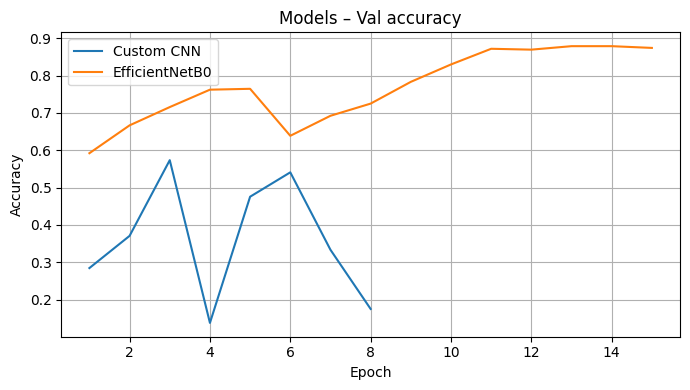

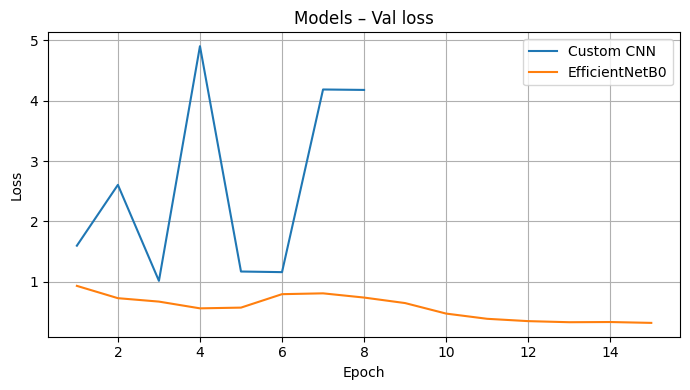

In [34]:
plot_compare_histories(
    {"Custom CNN": custom_history, "EfficientNetB0": eff_history},
    metric="accuracy",
    title="Models"
)

plot_compare_histories(
    {"Custom CNN": custom_history, "EfficientNetB0": eff_history},
    metric="loss",
    title="Models"
)
